<a href="https://colab.research.google.com/github/lszam/potentials-on/blob/main/PosdocON_GravCamposSantosRibeira_Etapa03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ambiente**

In [1]:
!pip install geopandas shapely matplotlib numpy pandas -q

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import shutil
import verde as vd
import requests

from shapely.geometry import Polygon


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 5.2 MB/s eta 0:00:00


In [2]:
!pip install pystac-client pyproj rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 5.4 MB/s eta 0:00:00


In [3]:
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from shapely.geometry import shape, Polygon, mapping

from pyproj import Transformer, CRS

import rasterio
from rasterio.plot import show
from rasterio.mask import mask

In [4]:
!apt-get install -y gdal-bin python3-gdal
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 4s (1,438 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 126284 files and directories curren

In [5]:
!pip install planetary_computer -q

In [6]:
!pip install cmocean -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 5.1 MB/s eta 0:00:00


In [7]:
import cmocean

###### Função para plotar 2 mapas do Brasil

In [8]:
def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.2, alpha=0.6)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=0.2, alpha=0.6)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

###### Haversine - distância em coordenadas lat long.

A fórmula Haversine pode ser usada para calcular a distância na esfera. Ela considera a curvatura da terra, mas pressupõe uma terra esférica em vez de um elipsoide. Para longas distâncias, a fórmula Haversine introduz um erro de menos de 0,1%. A altitude não é usada para calcular a distância. Mais em Microsoft Learn https://learn.microsoft.com/pt-br/dotnet/api/system.device.location.geocoordinate.getdistanceto?view=netframework-4.8.1

In [10]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos em km usando a fórmula de Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Raio médio da Terra em km
    return km

###### Função para encontrar pontos dentro de uma janela de raio específico

In [11]:
# Função para encontrar pontos dentro de uma janela de raio específico
def find_neighbors(gdf, index, window_size_km):
    """Encontra todos os pontos dentro de uma janela de raio específico em km."""
    lon, lat = gdf.loc[index, ['LONGITUDE', 'LATITUDE']]
    distances = gdf.apply(lambda row: haversine(lon, lat, row['LONGITUDE'], row['LATITUDE']), axis=1)
    neighbors = gdf[distances <= window_size_km]
    return neighbors

In [72]:
def plot_gdf_scatter(x, y, c, cmap, title, centered_to_zero = 'no'):
    try:
      import cmocean
    except:
      !pip install cmocean -q
      import cmocean
    import numpy as np
    import matplotlib.pyplot as plt

    if centered_to_zero == 'no':
      vmin = np.min(c)
      vmax = np.max(c)
    elif centered_to_zero == 'yes':
      vmin = -np.max(c)
      vmax = np.max(c)
    else:
      print('centered_to_zero must be yes or no')
      return

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        x, y,
        c=c,
        cmap=cmap,
        s=2,
        alpha=0.8,
        linewidth=0,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.02)
    cbar.set_label(title)
    plt.grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    plt.show()

# **Arquivos de entrada**

Sistema de coordenadas personalizado - policônica com datum sirgas 2000 lido a partir de dados gerados no Oasis Montaj

In [12]:
from pyproj import CRS

# String do .prj
wkt_string = '''PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'''

# Criar o objeto CRS a partir do WKT
crs_projeto = CRS.from_wkt(wkt_string)

# Verificar o CRS
print(crs_projeto)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


**Upload dos dados preparados na Etapa 2**

In [13]:
grav_gdf_offshore = gpd.read_file("grav_fa_offshore.gpkg")
grav_gdf_onshore = gpd.read_file("grav_fa_onshore.gpkg")

In [14]:
grav_gdf_offshore = grav_gdf_offshore.to_crs(crs_projeto)
print(grav_gdf_offshore.crs)
print(grav_gdf_offshore.head())

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]
   LATITUDE  LONGITUDE         FA        BAT                         geometry
0   -29.975 -50.108333 -33.415165  -9.249272  POINT (5375514.437 6676285.656)
1   -29.975 -50.091667 -29.462889 -13.559231  POINT (5377122.015 6676230.964)
2   -29.975 -50.075000 -24.403582 -16.029474  POINT (5378729.584 6676176.038)
3   -29.975 -50.058333 -19.615973 -21.713118  POINT (5380337.146 6676120.879)
4   -29.975 -50.041667 -16.353775 -23.119534  POINT (5381944.699 6676065.486)


In [15]:
grav_gdf_onshore = grav_gdf_onshore.to_crs(crs_projeto)
print(grav_gdf_onshore.crs)
print(grav_gdf_onshore.head())

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]
    LATITUDE  LONGITUDE   GRAV_OBS   ALT_ORTCO     FA_CORR         FA  \
0 -26.726082 -49.484579  978933.06  518.086182  159.049316  16.115110   
1 -26.733934 -49.478549  978933.21  522.671387  160.449524  17.097782   
2 -26.744365 -49.478098  978934.66  520.868408  159.898941  17.243218   
3 -26.752794 -49.473389  978937.82  517.515625  158.875076  18.769859   
4 -26.757917 -49.464726  978938.57  517.563477  158.889694  19.164027   

                          geometry  
0  POINT (5449164.322 7034759.678)  
1  POINT (5449732.972 7033866.688)  
2  POINT (5449736.738 7032707.276)  
3  POINT (5450171.613 7031754.912)  
4   POINT (54

In [20]:
# Concatenate the two GeoDataFrames
grav_gdf_all = pd.concat([grav_gdf_offshore, grav_gdf_onshore], ignore_index=True)

# Display the head of the combined GeoDataFrame and its length
print("Combined GeoDataFrame head:")
print(grav_gdf_all.head())
print("\nNumber of points in combined GeoDataFrame:", len(grav_gdf_all))

Combined GeoDataFrame head:
   LATITUDE  LONGITUDE         FA        BAT                         geometry  \
0   -29.975 -50.108333 -33.415165  -9.249272  POINT (5375514.437 6676285.656)   
1   -29.975 -50.091667 -29.462889 -13.559231  POINT (5377122.015 6676230.964)   
2   -29.975 -50.075000 -24.403582 -16.029474  POINT (5378729.584 6676176.038)   
3   -29.975 -50.058333 -19.615973 -21.713118  POINT (5380337.146 6676120.879)   
4   -29.975 -50.041667 -16.353775 -23.119534  POINT (5381944.699 6676065.486)   

   GRAV_OBS  ALT_ORTCO  FA_CORR  
0       NaN        NaN      NaN  
1       NaN        NaN      NaN  
2       NaN        NaN      NaN  
3       NaN        NaN      NaN  
4       NaN        NaN      NaN  

Number of points in combined GeoDataFrame: 404366


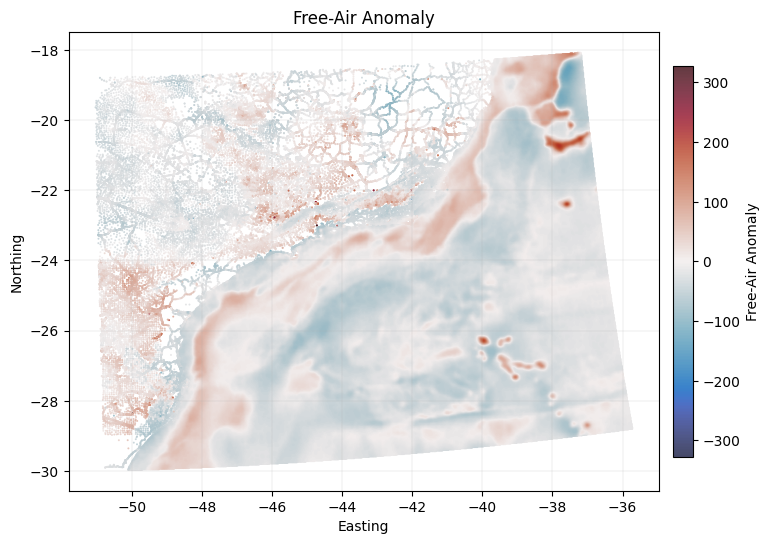

In [73]:
plot_gdf_scatter(grav_gdf_all.LONGITUDE, grav_gdf_all.LATITUDE, grav_gdf_all.FA, cmocean.cm.balance, 'Free-Air Anomaly', 'yes')

# **2. Redução dos dados 2 - Bouguer**


## **2.1 Onshore**

In [ ]:
!pip install harmonica -q

In [58]:
import harmonica as hm
import xarray as xr
from scipy.interpolate import griddata
import numpy as np

from google.colab import files

**Obtaining topographic values and making 2D xarray inputs**

In [48]:
x = grav_gdf_onshore.geometry.x.values
y = grav_gdf_onshore.geometry.y.values
topo = grav_gdf_onshore["ALT_ORTCO"].values

# Grid resolution
ncols, nrows = 200, 200
xi = np.linspace(x.min(), x.max(), ncols)
yi = np.linspace(y.min(), y.max(), nrows)
grid_x, grid_y = np.meshgrid(xi, yi)

grid_z = griddata((x, y), topo, (grid_x, grid_y), method="linear")

In [50]:
surface = xr.DataArray(
    grid_z,
    coords={"northing": yi, "easting": xi},
    dims=("northing", "easting")
)

density = xr.DataArray(
    2670 * np.ones_like(grid_z),
    coords={"northing": yi, "easting": xi},
    dims=("northing", "easting")
)

**Topography prisms layer**

In [53]:
prism_centers = (yi, xi)  # (northing, easting)

topo_prisms = hm.prism_layer(
    coordinates=(yi, xi),
    surface=surface.values,
    reference=0,
    properties={"density": density}
)

topo_prisms

<xarray.Dataset> Size: 963kB
Dimensions:   (northing: 200, easting: 200)
Coordinates:
  * easting   (easting) float64 2kB 6.685e+06 6.691e+06 ... 7.915e+06 7.921e+06
  * northing  (northing) float64 2kB 5.31e+06 5.316e+06 ... 6.502e+06 6.508e+06
    top       (northing, easting) float64 320kB nan nan nan nan ... nan nan nan
    bottom    (northing, easting) float64 320kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 320kB 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

In [55]:
coordinates = (grav_gdf_onshore.geometry.y, grav_gdf_onshore.geometry.x, grav_gdf_onshore["ALT_ORTCO"])
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

In [62]:
grav_gdf_onshore['GRAV_EFFECT'] = result
print(grav_gdf_onshore.head())

    LATITUDE  LONGITUDE   GRAV_OBS   ALT_ORTCO     FA_CORR         FA  \
0 -26.726082 -49.484579  978933.06  518.086182  159.049316  16.115110   
1 -26.733934 -49.478549  978933.21  522.671387  160.449524  17.097782   
2 -26.744365 -49.478098  978934.66  520.868408  159.898941  17.243218   
3 -26.752794 -49.473389  978937.82  517.515625  158.875076  18.769859   
4 -26.757917 -49.464726  978938.57  517.563477  158.889694  19.164027   

                          geometry  gravitational_effect  GRAV_EFFECT  
0  POINT (5449164.322 7034759.678)              0.009731     0.009731  
1  POINT (5449732.972 7033866.688)              0.010162     0.010162  
2  POINT (5449736.738 7032707.276)              0.010124     0.010124  
3  POINT (5450171.613 7031754.912)              0.009995     0.009995  
4   POINT (5451012.53 7031155.609)              0.010117     0.010117  


In [63]:
# Save the gravitational effect dataframe as CSV file
grav_effect = pd.DataFrame({
    'X': grav_gdf_onshore.geometry.x,
    'Y': grav_gdf_onshore.geometry.y,
    'GRAV_EFFECT': result
})


grav_effect.to_csv('gravitational_effect__onshore.csv', index=False)

print("Gravitational effect with coordinates saved as .csv")

from google.colab import files
files.download('gravitational_effect__onshore.csv')

Gravitational effect with coordinates saved as .csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Calculate and plot the Bouguer Anomaly**

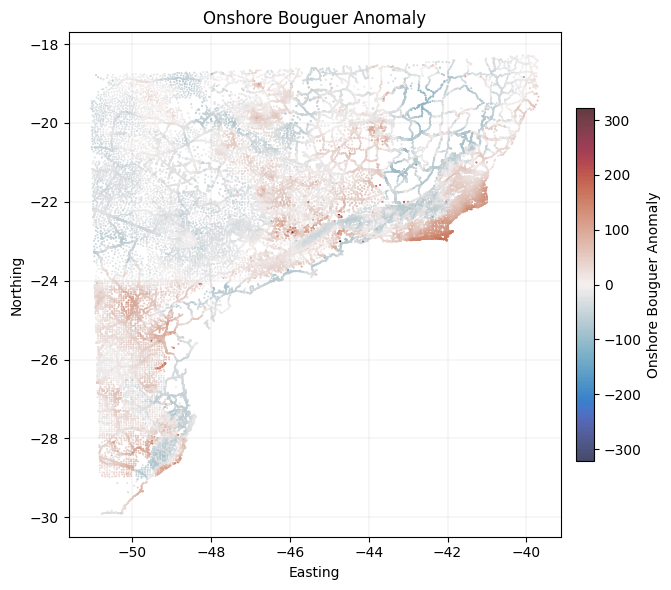

In [74]:
bouguer = grav_gdf_onshore['FA'] - grav_gdf_onshore['GRAV_EFFECT']
plot_gdf_scatter(grav_gdf_onshore.LONGITUDE, grav_gdf_onshore.LATITUDE, bouguer, cmocean.cm.balance, 'Onshore Bouguer Anomaly', centered_to_zero='yes')

In [76]:
# Create a pandas DataFrame with coordinates and gravitational effect
grav_effect = pd.DataFrame({
    'X': grav_gdf_onshore.geometry.x,
    'Y': grav_gdf_onshore.geometry.y,
    'ALT_ORTCO': grav_gdf_onshore["ALT_ORTCO"],
    'GRAV_EFFECT': result,
    'FA': grav_gdf_onshore['FA'],
    'BOUGUER': bouguer
})

# Save the DataFrame to a CSV file
grav_effect.to_csv('gravitational_effect_2670_onshore.csv', index=False)

# Download the file
from google.colab import files
files.download('gravitational_effect_2670_onshore.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
from shapely.geometry import Point
import geopandas as gpd

# Create the geometry
geometry = [Point(xy) for xy in zip(grav_effect['X'], grav_effect['Y'])]
grav_effect_gdf = gpd.GeoDataFrame(grav_effect, geometry=geometry)
grav_effect_gdf = grav_effect_gdf.set_crs(crs_projeto)

# Save the GeoDataFrame to a geopackage file
output_geopackage = 'grav_effect__onshore.gpkg'
grav_effect_gdf.to_file(output_geopackage, driver='GPKG')

from google.colab import files
files.download(output_geopackage)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Newly Bouguer for basin effects**

In [83]:
density_2300 = xr.DataArray(
    2300 * np.ones_like(grid_z),
    coords={"northing": yi, "easting": xi},
    dims=("northing", "easting")
)

prism_centers = (yi, xi)  # (northing, easting)

topo_prisms_2300 = hm.prism_layer(
    coordinates=(yi, xi),
    surface=surface.values,
    reference=0,
    properties={"density": density_2300}
)

topo_prisms_2300

<xarray.Dataset> Size: 963kB
Dimensions:   (northing: 200, easting: 200)
Coordinates:
  * easting   (easting) float64 2kB 6.685e+06 6.691e+06 ... 7.915e+06 7.921e+06
  * northing  (northing) float64 2kB 5.31e+06 5.316e+06 ... 6.502e+06 6.508e+06
    top       (northing, easting) float64 320kB nan nan nan nan ... nan nan nan
    bottom    (northing, easting) float64 320kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 320kB 2.3e+03 2.3e+03 ... 2.3e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

In [84]:
coordinates = (grav_gdf_onshore.geometry.y, grav_gdf_onshore.geometry.x, grav_gdf_onshore["ALT_ORTCO"])
result = topo_prisms_2300.prism_layer.gravity(coordinates, field="g_z")

In [85]:
grav_gdf_onshore['GRAV_EFFECT_2300'] = result
print(grav_gdf_onshore.head())

    LATITUDE  LONGITUDE   GRAV_OBS   ALT_ORTCO     FA_CORR         FA  \
0 -26.726082 -49.484579  978933.06  518.086182  159.049316  16.115110   
1 -26.733934 -49.478549  978933.21  522.671387  160.449524  17.097782   
2 -26.744365 -49.478098  978934.66  520.868408  159.898941  17.243218   
3 -26.752794 -49.473389  978937.82  517.515625  158.875076  18.769859   
4 -26.757917 -49.464726  978938.57  517.563477  158.889694  19.164027   

                          geometry  gravitational_effect  GRAV_EFFECT  \
0  POINT (5449164.322 7034759.678)              0.009731     0.009731   
1  POINT (5449732.972 7033866.688)              0.010162     0.010162   
2  POINT (5449736.738 7032707.276)              0.010124     0.010124   
3  POINT (5450171.613 7031754.912)              0.009995     0.009995   
4   POINT (5451012.53 7031155.609)              0.010117     0.010117   

   GRAV_EFFECT_2000  GRAV_EFFECT_2300  
0          0.007289          0.008382  
1          0.007612          0.008754  
2 

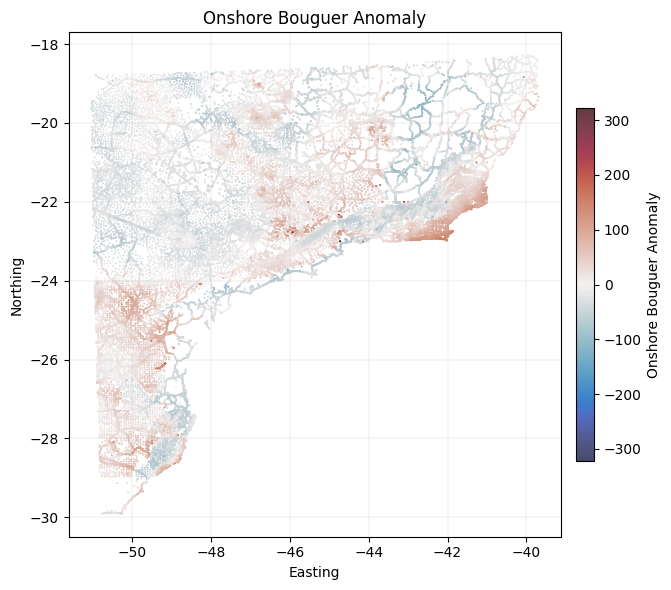

In [86]:
bouguer = grav_gdf_onshore['FA'] - grav_gdf_onshore['GRAV_EFFECT_2300']
plot_gdf_scatter(grav_gdf_onshore.LONGITUDE, grav_gdf_onshore.LATITUDE, bouguer, cmocean.cm.balance, 'Onshore Bouguer Anomaly', centered_to_zero='yes')

## **2.1 Offshore**

In [90]:
x = grav_gdf_offshore.geometry.x.values
y = grav_gdf_offshore.geometry.y.values
topo = grav_gdf_offshore["BAT"].values

# Grid resolution
ncols, nrows = 200, 200
xi = np.linspace(x.min(), x.max(), ncols)
yi = np.linspace(y.min(), y.max(), nrows)
grid_x, grid_y = np.meshgrid(xi, yi)

grid_z = griddata((x, y), topo, (grid_x, grid_y), method="linear")

In [91]:
surface = xr.DataArray(
    grid_z,
    coords={"northing": yi, "easting": xi},
    dims=("northing", "easting")
)

In [92]:
density_2000 = xr.DataArray(
    2000 * np.ones_like(grid_z),
    coords={"northing": yi, "easting": xi},
    dims=("northing", "easting")
)

In [93]:
prism_centers = (yi, xi)  # (northing, easting)

topo_prisms = hm.prism_layer(
    coordinates=(yi, xi),
    surface=surface.values,
    reference=0,
    properties={"density": density_2000}
)

topo_prisms

<xarray.Dataset> Size: 963kB
Dimensions:   (northing: 200, easting: 200)
Coordinates:
  * easting   (easting) float64 2kB 6.675e+06 6.681e+06 ... 7.915e+06 7.921e+06
  * northing  (northing) float64 2kB 5.376e+06 5.383e+06 ... 6.771e+06 6.778e+06
    top       (northing, easting) float64 320kB nan nan nan nan ... nan nan nan
    bottom    (northing, easting) float64 320kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 320kB 2e+03 2e+03 ... 2e+03 2e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

In [ ]:
coordinates = (grav_gdf_offshore.geometry.y, grav_gdf_offshore.geometry.x, grav_gdf_offshore["BAT"])
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

In [ ]:
grav_gdf_offshore['GRAV_EFFECT_2000'] = result
print(grav_gdf_offshore.head())

In [ ]:
bouguer = grav_gdf_offshore['FA'] + grav_gdf_offshore['GRAV_EFFECT_2000']
plot_gdf_scatter(grav_gdf_offshore.LONGITUDE, grav_gdf_offshore.LATITUDE, bouguer, cmocean.cm.balance, 'Offshore Bouguer Anomaly', centered_to_zero='yes')

**Alternative density value**

In [ ]:
density_2300 = xr.DataArray(
    2300 * np.ones_like(grid_z),
    coords={"northing": yi, "easting": xi},
    dims=("northing", "easting")
)

prism_centers = (yi, xi)  # (northing, easting)

topo_prisms = hm.prism_layer(
    coordinates=(yi, xi),
    surface=surface.values,
    reference=0,
    properties={"density": density_2300}
)

coordinates = (grav_gdf_offshore.geometry.y, grav_gdf_offshore.geometry.x, grav_gdf_offshore["BAT"])
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")